In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from packages.DataProcessing import split_dataset, tfrecords

In [2]:
df = pd.read_csv("./input/train.csv")

In [3]:
class_names = [       "Abdomen",        "Ankle", "Cervical Spine",  "Chest", 
                    "Clavicles",        "Elbow",           "Feet", "Finger",
                      "Forearm",         "Hand",            "Hip",   "Knee",  
                    "Lower Leg", "Lumbar Spine",         "Others", "Pelvis", 
                     "Shoulder",        "Sinus",          "Skull",  "Thigh", 
               "Thoracic Spine",        "Wrist"]

In [4]:
targets = np.zeros((len(df.Target), 22), dtype=int)
for i, t in enumerate(df.Target):
    target = t.strip().split()
    for j in target:
        targets[i, int(j)] = 1

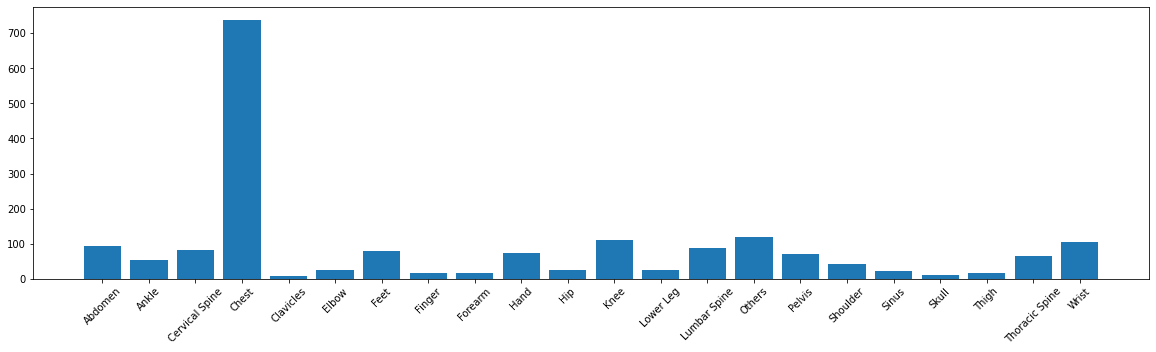

In [5]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(22), targets.sum(axis=0))
plt.xticks(ticks=np.arange(22), labels=class_names, rotation=45)
plt.show()

In [6]:
path_images = []
folder = ".\\input\\train\\train\\"
for root, dirs, files in os.walk(folder, topdown=False):
    if files:
        if files[0][-3:] == 'dcm':
            path_images.append(root + "\\" + files[0])

In [7]:
for i in range(len(df)):
    id = df.iloc[i].SOPInstanceUID
    for j in path_images:
        if j[-70:-6] == id:
            df.iloc[i].SOPInstanceUID = j
            break

In [8]:
df.head()

,SOPInstanceUID,Target
0,.\input\train\train\1332\1.2.826.0.1.3680043.8...,0
1,.\input\train\train\299\1.2.826.0.1.3680043.8....,15
2,.\input\train\train\259\1.2.826.0.1.3680043.8....,12
3,.\input\train\train\129\1.2.826.0.1.3680043.8....,14
4,.\input\train\train\365\1.2.826.0.1.3680043.8....,3


In [9]:
ds_splits = split_dataset(X=df.SOPInstanceUID, y=targets)

train size: 1304
valid size: 434


In [10]:
# Writing TFRecords
records = tfrecords(1024, 1024)

records.WriteTFRecords(ds_splits, path='./output/tfrecords')

100%|██████████| 434/434 [22:17<00:00,  3.08s/it]


In [11]:
# Reading TFRecords
records = tfrecords(1024, 1024)
train_ds = records.get_dataset('./output/tfrecords/train.tfrecords')
valid_ds = records.get_dataset('./output/tfrecords/valid.tfrecords')

In [12]:
BATCH_SIZE=16
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

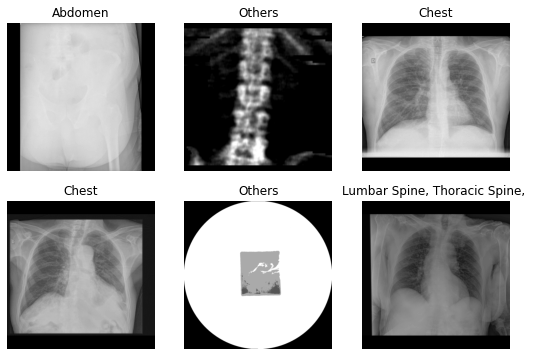

In [17]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().reshape(1024, 1024), cmap='gray')
    label = label_batch[i].numpy()
    if label.sum() == 1:
        plt.title(class_names[np.argmax(label)])
    else:
        titles = ""
        for j in np.where(label == 1)[0]:
            titles = titles + class_names[j] + ", "
        plt.title(titles)
    plt.axis("off")
plt.show()